In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import chi2
import itertools

%matplotlib inline

In [100]:
import warnings
warnings.filterwarnings("ignore")

## ARIMA Model

***ARIMA stands for Autoregressive Integrated Moving Average model. Although ARMA was a better model, it still fails to be a good predictor when data is non-stationary. This can be solved using ARIMA, as it can handle non-stationary series.***

***ARIMA(p, d, q)***

$$ARIMA(p, d, q): \Delta X(t) = C +  (\delta_1 \cdot \Delta X(t - 1) + \dotso + \delta_p \cdot \Delta X(t - p)) +
                                      (\theta_1 \cdot Er(t - 1) + \dotso + \theta_q \cdot Er(t - q)) + Er(t) $$
                                      
$$\text{where, }$$
$$\Delta X(t) = X(t) - X(t - 1)$$

In [77]:
actual_data = pd.read_csv("../../datasets/stock_prices/index_2018.csv")
df = actual_data.copy()
df.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [78]:
df["date"] = pd.to_datetime(df["date"], dayfirst=True)
df_index = df["date"]
df.drop("date", axis=1, inplace=True)
df.index = df_index
df.index.name = None

df = df.asfreq("b")

df = df.apply(lambda x: x.fillna(method="ffill"))

df_spx = pd.DataFrame(df["spx"])
df_ftse = pd.DataFrame(df["ftse"])

df_ftse["returns"] = df_ftse["ftse"].pct_change(1)

In [79]:
def LLR_test(model1, model2, df=1):
    """
        model1 -> First model
        model2 -> Second model
        df -> Degrees of freedom(default 1 as we are generally comparing models of only one order difference)
    """
    L1 = model1.fit().llf
    L2 = model2.fit().llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, df).round(4)
    return p

## ARIMA(P, D, Q)

In [104]:
def tsplot(data, lags):
    with plt.style.context("bmh"):
        layout = (2, 2)
        plt.figure(figsize=(15, 7))
        plot_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        data.plot(ax=plot_ax)
        p_value = sts.adfuller(data)[1]
        plot_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        sgt.plot_acf(data, lags=lags, zero=False, unbiased=True, ax=acf_ax, title="ACF Returns")
        sgt.plot_pacf(data, lags=lags, zero=False, method="ols", ax=pacf_ax, title="PACF Returns")
        plt.grid(True)
        plt.show()

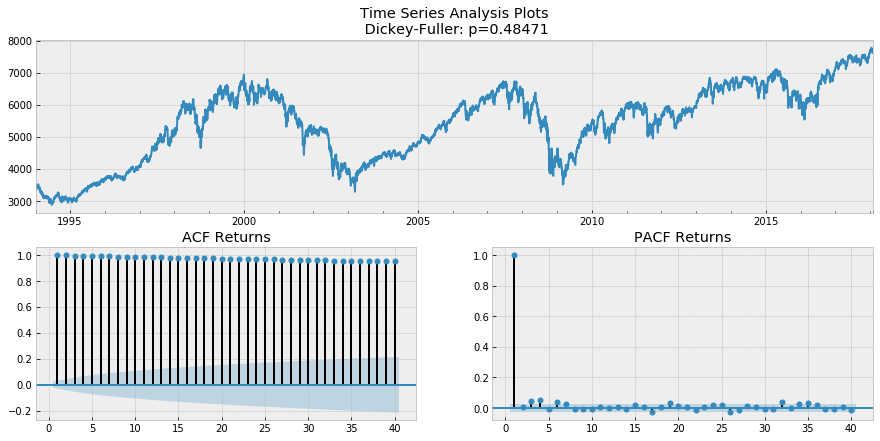

In [81]:
tsplot(df_ftse["ftse"], lags=40)

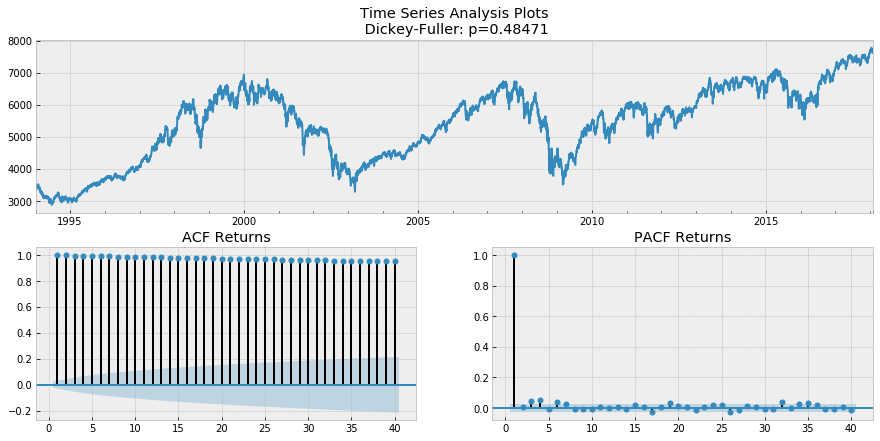

In [113]:
ftse_diff = df_ftse["ftse"]
tsplot(ftse_diff, lags=40)

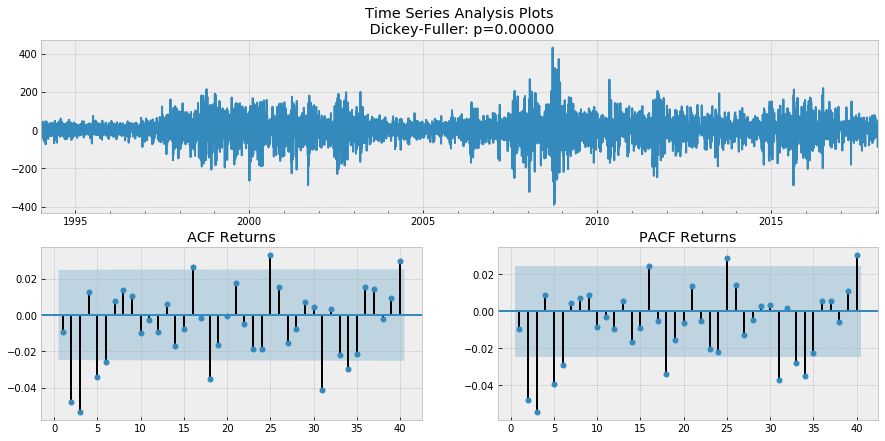

In [114]:
ftse_diff = ftse_diff - ftse_diff.shift(1)
tsplot(ftse_diff[1:], lags=40)

***P(PACF) -> 6, Q(ACF) -> 8***

In [123]:
def ARIMA_test(data, ar_order, io, ma_order):
    count = 0
    for ar_i in range(1, ar_order+1):
        for ma_i in [ar_i-2, ar_i-1, ar_i, ar_i+1, ar_i+2]:
            try:
                model = ARIMA(data, order=(ar_i, io, ma_i))
                result = model.fit()
                print("ARIMA({}, {}, {}) --> LLF: {:.2f}, p-value: {:.5f}, IC(AIC, BIC, HQIC): ({:.2f}, {:.2f}, {:.2f})".format(ar_i,
                                                                                                   io, ma_i, result.llf, 
                                                                                                   result.pvalues[-1], 
                                                                                                   result.aic, result.bic, result.hqic))
                if ar_i > 1 and ma_i > 1:
                    llr_test_p_values = LLR_test(ARIMA(data, order=(ar_i-1, io, ma_i-1)), ARIMA(data, 
                                                                                     order=(ar_i, io, ma_i)),
                                                 df=(ar_i+ma_i)-(ar_i+ma_i-2))
                    print("LLR Test for ARIMA({}, {}, {}) and ARIMA({}, {}, {}) p-value: {}".format(ar_i-1, io, ma_i-1, ar_i, io,
                                                                                                    ma_i, llr_test_p_values))
                    if llr_test_p_values > 0.05:
                        print("ARIMA({}, {}, {}) is insignificant, exiting.".format(ar_i, io, ma_i))
                        return
                print("-----------------------------------------------------------------------------------------------")
            except ValueError:
                count += 1
                if count <= 10:
                    print("Skipping ARIMA({}, {}, {}), can't compute coefficients due to non-stationarity.".format(ar_i,
                                                                                                                   io, ma_i))
                    print("-----------------------------------------------------------------------------------------------")
                else:
                    print("Exiting, can't compute ARIMA({}, {}, {}) coefficients due to non-stationarity.".format(ar_i,
                                                                                                                  io, ma_i))
                    print("-----------------------------------------------------------------------------------------------")
                    return

In [126]:
ARIMA_test(df_ftse["ftse"], 5, 1, 5)

Skipping ARIMA(1, 1, -1), can't compute coefficients due to non-stationarity.
-----------------------------------------------------------------------------------------------
ARIMA(1, 1, 0) --> LLF: -34429.81, p-value: 0.46009, IC(AIC, BIC, HQIC): (68865.61, 68885.85, 68872.63)
-----------------------------------------------------------------------------------------------
ARIMA(1, 1, 1) --> LLF: -34417.64, p-value: 0.00000, IC(AIC, BIC, HQIC): (68843.29, 68870.26, 68852.63)
-----------------------------------------------------------------------------------------------
ARIMA(1, 1, 2) --> LLF: -34413.66, p-value: 0.00193, IC(AIC, BIC, HQIC): (68837.33, 68871.05, 68849.01)
-----------------------------------------------------------------------------------------------
ARIMA(1, 1, 3) --> LLF: -34410.78, p-value: 0.00000, IC(AIC, BIC, HQIC): (68833.56, 68874.03, 68847.58)
-----------------------------------------------------------------------------------------------
ARIMA(2, 1, 0) --> LLF: -3

## ARIMA (4, 1, 2)

In [127]:
xyz = ARIMA(df_ftse["ftse"], order=(4, 1, 2)).fit().resid

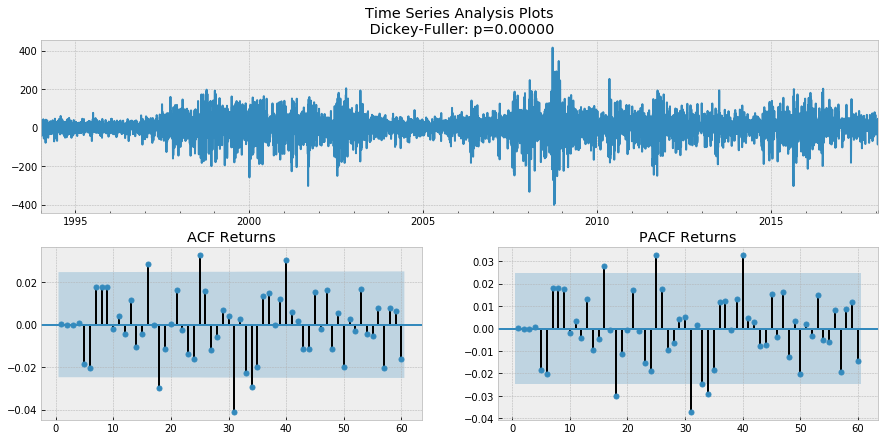

In [128]:
tsplot(xyz, lags=60)